In [1]:
from dataset.dataset import *
from models.involution import * 
from models.unet import *

In [2]:
import math
import numpy as np
import torch 
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim

from PIL import Image
import glob

import matplotlib.pyplot as plt
import os 
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import datetime
import logging

In [3]:
import os
import torch 
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

## O Haze Dataset

In [4]:
class OHaze(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        self.haze_dir = os.path.join(data_dir, "hazy")
        self.clean_dir = os.path.join(data_dir, "GT")

        # Sort for consistency
        self.haze_images = sorted(os.listdir(self.haze_dir))  
        self.clean_images = sorted(os.listdir(self.clean_dir))  

        # Error handling if number of haze and clear images don't match
        if len(self.haze_images) != len(self.clean_images):
            raise ValueError("Number of haze images does not match number of clear images.")

    def __len__(self):
        return len(self.haze_images)

    def __getitem__(self, idx):
        haze_image_name = self.haze_images[idx]
        clean_image_name = self.clean_images[idx]
        haze_image_path = os.path.join(self.haze_dir, haze_image_name)
        clean_image_path = os.path.join(self.clean_dir, clean_image_name)

 
        haze_image = Image.open(haze_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            haze_image = self.transform(haze_image)
            clean_image = self.transform(clean_image)

        return haze_image, clean_image

In [5]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_dir = './dataset/O-HAZE/# O-HAZY NTIRE 2018'
ohaze_dataset = OHaze(dataset_dir, transform)

In [6]:
len(ohaze_dataset)

45

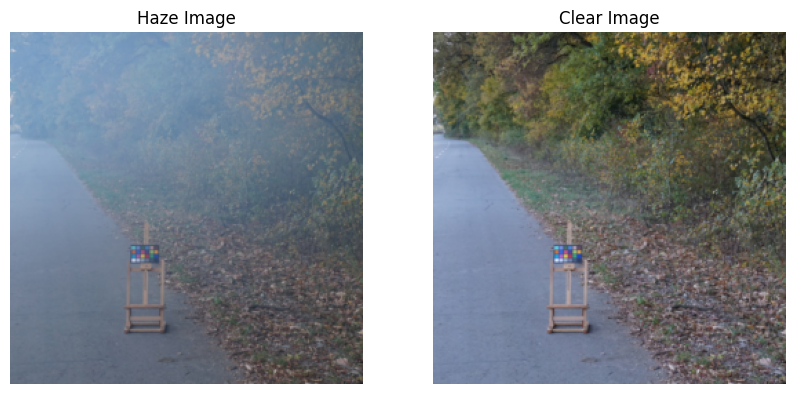

In [7]:
# Access an item from the dataset
index = 0  # Change this to test different images
haze_image, clear_image = ohaze_dataset[index]

# print(haze_image)
# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Indices for splitting
total_size = len(ohaze_dataset)
indices = list(range(total_size))

# Split indices: 35 training, 5 validation, 5 test
train_indices, test_indices = train_test_split(indices, test_size=10, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=5, random_state=42)

print(f'Training indices: {len(train_indices)}')
print(f'Validation indices: {len(val_indices)}')
print(f'Test indices: {len(test_indices)}')

# Create Subset datasets
train_dataset = Subset(ohaze_dataset, train_indices)
val_dataset = Subset(ohaze_dataset, val_indices)
test_dataset = Subset(ohaze_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example usage
print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))



Training indices: 35
Validation indices: 5
Test indices: 5
Number of training samples: 9
Number of validation samples: 5
Number of test samples: 5


In [12]:
from utils.metrics import psnr
from utils.train_evalute import *

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNET(in_channels = 3, out_channels = 3).to(device)
epochs = 50
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './weights/model_20240517_032535.pth'
model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [11]:
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = os.path.join(log_dir, f"training_OHAZE_FT_{timestamp}.log")
val_logfile = os.path.join(log_dir, f"val_OHAZE_FT_{timestamp}.log")

def setup_logger(logger_name, log_file, level=logging.INFO):
    """Function to setup logger"""

    logger = logging.getLogger(logger_name)
    # Create a custom logger
    handler = logging.FileHandler(log_file)    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    handler.setFormatter(formatter)

    logger.setLevel(level)
    logger.addHandler(handler)
    
    return logger

train_log = setup_logger('train_log', log_file)
val_log = setup_logger('val_log', val_logfile)

In [12]:
history = train_and_evaluate(model, train_loader, val_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size = 1, fine_tune = 'OHAZE')

Training Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.0198, Val Loss: 0.0268, PSNR: 16.473237991333008, SSIM: 0.6164614498615265
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 2/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.0127, Val Loss: 0.0122, PSNR: 19.529489517211914, SSIM: 0.7453026890754699
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 3/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.0109, Val Loss: 0.0109, PSNR: 19.9603328704834, SSIM: 0.767929470539093
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 4/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.0092, Val Loss: 0.0105, PSNR: 20.24410629272461, SSIM: 0.7691350698471069
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 5/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.0101, Val Loss: 0.0094, PSNR: 20.69692039489746, SSIM: 0.786828875541687
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 6/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.0081, Val Loss: 0.0087, PSNR: 21.177595138549805, SSIM: 0.7919404149055481
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 7/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.0072, Val Loss: 0.0091, PSNR: 20.97279930114746, SSIM: 0.7993406176567077
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 8/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.0078, Val Loss: 0.0090, PSNR: 20.962230682373047, SSIM: 0.8072276711463928
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 9/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.0072, Val Loss: 0.0089, PSNR: 21.140426635742188, SSIM: 0.8034234166145324
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 10/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.0070, Val Loss: 0.0086, PSNR: 21.33062744140625, SSIM: 0.8039489626884461
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 11/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.0066, Val Loss: 0.0085, PSNR: 21.469022750854492, SSIM: 0.8048737168312072
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 12/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.0067, Val Loss: 0.0079, PSNR: 21.511018753051758, SSIM: 0.8133060216903687
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 13/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.0075, Val Loss: 0.0080, PSNR: 21.5675106048584, SSIM: 0.8124846935272216
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 14/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.0063, Val Loss: 0.0081, PSNR: 21.6740665435791, SSIM: 0.8105965852737427
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 15/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.0061, Val Loss: 0.0082, PSNR: 21.750051498413086, SSIM: 0.8108154773712158
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 16/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.0064, Val Loss: 0.0078, PSNR: 21.85627555847168, SSIM: 0.8138400912284851
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 17/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.0059, Val Loss: 0.0083, PSNR: 21.46516990661621, SSIM: 0.8121623754501343
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 18/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.0057, Val Loss: 0.0087, PSNR: 21.376564025878906, SSIM: 0.8068806767463684
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 19/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.0050, Val Loss: 0.0083, PSNR: 21.675880432128906, SSIM: 0.8146181344985962
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 20/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.0054, Val Loss: 0.0085, PSNR: 21.82196617126465, SSIM: 0.8132506489753724
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 21/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.0057, Val Loss: 0.0086, PSNR: 21.54300308227539, SSIM: 0.8136777400970459
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 22/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.0054, Val Loss: 0.0086, PSNR: 21.5410213470459, SSIM: 0.8092242121696472
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 23/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.0052, Val Loss: 0.0083, PSNR: 21.448118209838867, SSIM: 0.8184979438781739
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 24/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.0055, Val Loss: 0.0086, PSNR: 21.692529678344727, SSIM: 0.8156615376472474
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 25/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.0047, Val Loss: 0.0087, PSNR: 21.497804641723633, SSIM: 0.8168710231781006
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 26/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.0050, Val Loss: 0.0088, PSNR: 21.626266479492188, SSIM: 0.8145525932312012
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 27/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.0049, Val Loss: 0.0087, PSNR: 21.69642448425293, SSIM: 0.8171816110610962
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 28/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.0054, Val Loss: 0.0081, PSNR: 21.813894271850586, SSIM: 0.8222576379776001
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 29/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 0.0046, Val Loss: 33.5649, PSNR: 12.508890151977539, SSIM: 0.8191647052764892
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 30/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 0.0050, Val Loss: 0.0193, PSNR: 19.349143981933594, SSIM: 0.8214688777923584
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 31/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 0.0044, Val Loss: 0.0079, PSNR: 21.9343318939209, SSIM: 0.8238434672355652
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 32/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 0.0043, Val Loss: 0.0086, PSNR: 21.909435272216797, SSIM: 0.8206762671470642
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 33/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 0.0041, Val Loss: 0.0082, PSNR: 21.84175682067871, SSIM: 0.8250134825706482
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 34/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 0.0043, Val Loss: 0.0086, PSNR: 21.90387535095215, SSIM: 0.824057137966156
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 35/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 0.0042, Val Loss: 0.0090, PSNR: 21.7078800201416, SSIM: 0.8202358484268188
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 36/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 0.0045, Val Loss: 0.0088, PSNR: 21.806997299194336, SSIM: 0.8213219761848449
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 37/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 0.0041, Val Loss: 0.0086, PSNR: 21.994977951049805, SSIM: 0.8253223776817322
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 38/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 0.0041, Val Loss: 0.0091, PSNR: 21.974872589111328, SSIM: 0.8216735243797302
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 39/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 0.0040, Val Loss: 0.0086, PSNR: 21.879972457885742, SSIM: 0.8279141902923584
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 40/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 0.0046, Val Loss: 0.0081, PSNR: 21.898792266845703, SSIM: 0.828831946849823
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 41/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/100
Train Loss: 0.0040, Val Loss: 0.0089, PSNR: 21.8653564453125, SSIM: 0.8227509498596192
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 42/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/100
Train Loss: 0.0046, Val Loss: 0.0083, PSNR: 21.70377540588379, SSIM: 0.8287998080253601
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 43/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/100
Train Loss: 0.0040, Val Loss: 0.0092, PSNR: 21.705110549926758, SSIM: 0.8227874875068665
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 44/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/100
Train Loss: 0.0040, Val Loss: 0.0077, PSNR: 21.939376831054688, SSIM: 0.8292404770851135
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 45/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/100
Train Loss: 0.0036, Val Loss: 0.0087, PSNR: 21.8211727142334, SSIM: 0.825536060333252
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 46/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/100
Train Loss: 0.0035, Val Loss: 0.0089, PSNR: 21.8298282623291, SSIM: 0.8278285145759583
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 47/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/100
Train Loss: 0.0034, Val Loss: 0.0096, PSNR: 21.822513580322266, SSIM: 0.8229274153709412
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 48/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/100
Train Loss: 0.0036, Val Loss: 0.0091, PSNR: 21.824583053588867, SSIM: 0.8265336632728577
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 49/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/100
Train Loss: 0.0034, Val Loss: 0.0093, PSNR: 21.910667419433594, SSIM: 0.8264219522476196
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 50/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/100
Train Loss: 0.0033, Val Loss: 0.0097, PSNR: 22.030057907104492, SSIM: 0.8244127035140991
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 51/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/100
Train Loss: 0.0033, Val Loss: 0.0086, PSNR: 22.110143661499023, SSIM: 0.8320204734802246
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 52/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/100
Train Loss: 0.0033, Val Loss: 0.0088, PSNR: 22.005666732788086, SSIM: 0.8300597667694092
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 53/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/100
Train Loss: 0.0032, Val Loss: 0.0089, PSNR: 21.884435653686523, SSIM: 0.8296085953712463
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 54/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/100
Train Loss: 0.0035, Val Loss: 0.0090, PSNR: 21.890947341918945, SSIM: 0.8277922987937927
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 55/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/100
Train Loss: 0.0034, Val Loss: 0.0095, PSNR: 21.179452896118164, SSIM: 0.8349616408348084
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 56/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/100
Train Loss: 0.0035, Val Loss: 0.0086, PSNR: 22.247730255126953, SSIM: 0.8330841898918152
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 57/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/100
Train Loss: 0.0034, Val Loss: 0.0082, PSNR: 22.205581665039062, SSIM: 0.8360448241233825
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 58/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/100
Train Loss: 0.0036, Val Loss: 0.0081, PSNR: 22.050064086914062, SSIM: 0.8364819169044495
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 59/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/100
Train Loss: 0.0033, Val Loss: 0.0081, PSNR: 21.992801666259766, SSIM: 0.8369915962219239
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 60/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/100
Train Loss: 0.0030, Val Loss: 0.0078, PSNR: 22.366186141967773, SSIM: 0.8363446712493896
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 61/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/100
Train Loss: 0.0031, Val Loss: 0.0082, PSNR: 22.139551162719727, SSIM: 0.8330376744270325
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 62/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/100
Train Loss: 0.0031, Val Loss: 0.0085, PSNR: 22.120969772338867, SSIM: 0.8321834444999695
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 63/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/100
Train Loss: 0.0031, Val Loss: 0.0085, PSNR: 22.054927825927734, SSIM: 0.8350776791572571
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 64/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/100
Train Loss: 0.0036, Val Loss: 0.0079, PSNR: 22.145429611206055, SSIM: 0.8374189257621765
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 65/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/100
Train Loss: 0.0032, Val Loss: 0.0092, PSNR: 21.810667037963867, SSIM: 0.829953932762146
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 66/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/100
Train Loss: 0.0029, Val Loss: 0.0087, PSNR: 21.881183624267578, SSIM: 0.8341941237449646
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 67/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/100
Train Loss: 0.0030, Val Loss: 0.0095, PSNR: 21.8131160736084, SSIM: 0.8276933193206787
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 68/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/100
Train Loss: 0.0036, Val Loss: 0.0088, PSNR: 21.971511840820312, SSIM: 0.8348315358161926
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 69/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69/100
Train Loss: 0.0029, Val Loss: 0.0089, PSNR: 22.120380401611328, SSIM: 0.834174656867981
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 70/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70/100
Train Loss: 0.0030, Val Loss: 0.0084, PSNR: 22.160337448120117, SSIM: 0.8359307765960693
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 71/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71/100
Train Loss: 0.0030, Val Loss: 0.0075, PSNR: 22.202163696289062, SSIM: 0.8412447690963745
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 72/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72/100
Train Loss: 0.0031, Val Loss: 0.0083, PSNR: 22.28790855407715, SSIM: 0.8355411887168884
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 73/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73/100
Train Loss: 0.0030, Val Loss: 0.0078, PSNR: 22.296539306640625, SSIM: 0.8395823955535888
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 74/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74/100
Train Loss: 0.0029, Val Loss: 0.0084, PSNR: 21.966779708862305, SSIM: 0.8360904097557068
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 75/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75/100
Train Loss: 0.0029, Val Loss: 0.0084, PSNR: 22.08513641357422, SSIM: 0.8366721868515015
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 76/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76/100
Train Loss: 0.0028, Val Loss: 0.0093, PSNR: 21.794240951538086, SSIM: 0.8296276450157165
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 77/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77/100
Train Loss: 0.0029, Val Loss: 0.0087, PSNR: 22.06591796875, SSIM: 0.8350896120071412
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 78/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78/100
Train Loss: 0.0030, Val Loss: 0.0088, PSNR: 22.1345272064209, SSIM: 0.8333566069602967
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 79/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79/100
Train Loss: 0.0028, Val Loss: 0.0088, PSNR: 22.19523048400879, SSIM: 0.8350465059280395
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 80/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80/100
Train Loss: 0.0027, Val Loss: 0.0085, PSNR: 22.383798599243164, SSIM: 0.8383983254432679
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 81/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81/100
Train Loss: 0.0026, Val Loss: 0.0079, PSNR: 22.208192825317383, SSIM: 0.8422438383102417
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 82/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82/100
Train Loss: 0.0029, Val Loss: 0.0086, PSNR: 22.145660400390625, SSIM: 0.835163688659668
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 83/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83/100
Train Loss: 0.0028, Val Loss: 0.0080, PSNR: 22.500167846679688, SSIM: 0.8415152192115783
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 84/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84/100
Train Loss: 0.0026, Val Loss: 0.0082, PSNR: 22.337350845336914, SSIM: 0.8389214634895324
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 85/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85/100
Train Loss: 0.0028, Val Loss: 0.0082, PSNR: 22.1879825592041, SSIM: 0.8378244042396545
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 86/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86/100
Train Loss: 0.0026, Val Loss: 0.0084, PSNR: 22.29989242553711, SSIM: 0.8370457649230957
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 87/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87/100
Train Loss: 0.0027, Val Loss: 0.0084, PSNR: 22.101167678833008, SSIM: 0.8381019353866577
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 88/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88/100
Train Loss: 0.0028, Val Loss: 0.0089, PSNR: 22.01144027709961, SSIM: 0.8361593246459961
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 89/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89/100
Train Loss: 0.0025, Val Loss: 0.0087, PSNR: 22.11843490600586, SSIM: 0.837821364402771
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 90/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90/100
Train Loss: 0.0025, Val Loss: 0.0095, PSNR: 22.039804458618164, SSIM: 0.8328133463859558
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 91/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91/100
Train Loss: 0.0027, Val Loss: 0.0093, PSNR: 22.018817901611328, SSIM: 0.8342865467071533
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 92/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92/100
Train Loss: 0.0026, Val Loss: 0.0091, PSNR: 22.044809341430664, SSIM: 0.836144745349884
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 93/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93/100
Train Loss: 0.0025, Val Loss: 0.0093, PSNR: 22.138898849487305, SSIM: 0.8346962690353393
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 94/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94/100
Train Loss: 0.0025, Val Loss: 0.0086, PSNR: 22.161008834838867, SSIM: 0.841008472442627
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 95/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95/100
Train Loss: 0.0025, Val Loss: 0.0083, PSNR: 22.200464248657227, SSIM: 0.8429524898529053
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 96/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96/100
Train Loss: 0.0025, Val Loss: 0.0079, PSNR: 22.26771354675293, SSIM: 0.847319483757019
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 97/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97/100
Train Loss: 0.0026, Val Loss: 0.0083, PSNR: 22.319272994995117, SSIM: 0.8422708630561828
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 98/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98/100
Train Loss: 0.0024, Val Loss: 0.0079, PSNR: 22.380416870117188, SSIM: 0.8440941095352172
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 99/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99/100
Train Loss: 0.0026, Val Loss: 12.1813, PSNR: 13.876113891601562, SSIM: 0.8430575609207154
Model saved as weights/model_OHAZE_20240517_055202.pth


Training Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 100/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100/100
Train Loss: 0.0028, Val Loss: 0.8695, PSNR: 15.973876953125, SSIM: 0.8408889532089233
Model saved as weights/model_OHAZE_20240517_055202.pth


In [17]:
valid_per_epoch(model, test_loader, criterion, device, 0, 
                    100, val_log, batch_size = 1, display = False)

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

(0.009808425419032573, tensor(20.5931, device='cuda:0'), 0.7894145250320435)

## Dense Haze Dataset

In [4]:
class DenseHaze(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        self.haze_dir = os.path.join(data_dir, "hazy")
        self.clean_dir = os.path.join(data_dir, "GT")

        # Sort for consistency
        self.haze_images = sorted(os.listdir(self.haze_dir))  
        self.clean_images = sorted(os.listdir(self.clean_dir))  

        # Error handling if number of haze and clear images don't match
        if len(self.haze_images) != len(self.clean_images):
            raise ValueError("Number of haze images does not match number of clear images.")

    def __len__(self):
        return len(self.haze_images)

    def __getitem__(self, idx):
        haze_image_name = self.haze_images[idx]
        clean_image_name = self.clean_images[idx]
        haze_image_path = os.path.join(self.haze_dir, haze_image_name)
        clean_image_path = os.path.join(self.clean_dir, clean_image_name)

 
        haze_image = Image.open(haze_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            haze_image = self.transform(haze_image)
            clean_image = self.transform(clean_image)

        return haze_image, clean_image

In [6]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_dir = './dataset/Dense-HAZE/'
dhaze_dataset = DenseHaze(dataset_dir, transform)

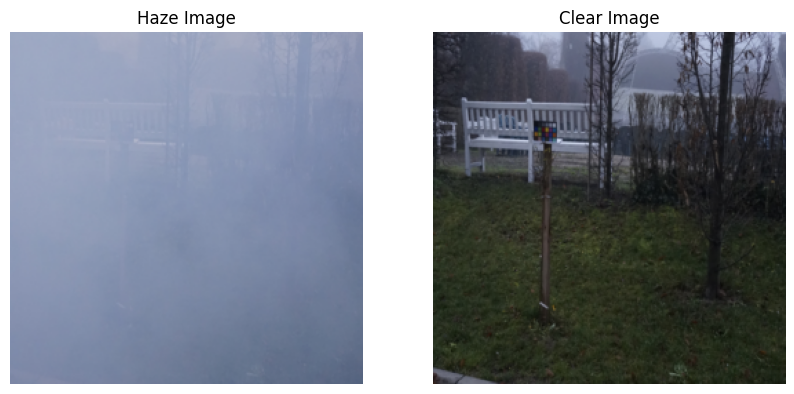

In [7]:
# Access an item from the dataset
index = 0  # Change this to test different images
haze_image, clear_image = dhaze_dataset[index]

# print(haze_image)
# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Indices for splitting
total_size = len(dhaze_dataset)
indices = list(range(total_size))

# Split indices: 45 training, 5 validation, 5 test
train_indices, test_indices = train_test_split(indices, test_size=10, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=5, random_state=42)

print(f'Training indices: {len(train_indices)}')
print(f'Validation indices: {len(val_indices)}')
print(f'Test indices: {len(test_indices)}')

# Create Subset datasets
train_dataset = Subset(dhaze_dataset, train_indices)
val_dataset = Subset(dhaze_dataset, val_indices)
test_dataset = Subset(dhaze_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example usage
print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))



Training indices: 45
Validation indices: 5
Test indices: 5
Number of training samples: 12
Number of validation samples: 5
Number of test samples: 5


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNET(in_channels = 3, out_channels = 3).to(device)
epochs = 50
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './weights/model_20240517_032535.pth'
model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = os.path.join(log_dir, f"training_DHAZE_FT_{timestamp}.log")
val_logfile = os.path.join(log_dir, f"val_DHAZE_FT_{timestamp}.log")

def setup_logger(logger_name, log_file, level=logging.INFO):
    """Function to setup logger"""

    logger = logging.getLogger(logger_name)
    # Create a custom logger
    handler = logging.FileHandler(log_file)    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    handler.setFormatter(formatter)

    logger.setLevel(level)
    logger.addHandler(handler)
    
    return logger

train_log = setup_logger('train_log', log_file)
val_log = setup_logger('val_log', val_logfile)

In [19]:
history = train_and_evaluate(model, train_loader, val_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size = 1, fine_tune = 'DHAZE')

Training Epoch 1/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 1/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
Train Loss: 0.0509, Val Loss: 7.7862, PSNR: 7.658846378326416, SSIM: 0.3604390561580658
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 2/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 2/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/50
Train Loss: 0.0384, Val Loss: 102.5402, PSNR: 6.234455108642578, SSIM: 0.39102715253829956
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 3/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 3/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/50
Train Loss: 0.0349, Val Loss: 0.0531, PSNR: 14.212973594665527, SSIM: 0.4097515165805817
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 4/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 4/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/50
Train Loss: 0.0364, Val Loss: 0.0297, PSNR: 15.541444778442383, SSIM: 0.4157249450683594
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 5/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 5/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/50
Train Loss: 0.0341, Val Loss: 0.4454, PSNR: 12.000764846801758, SSIM: 0.42803117632865906
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 6/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 6/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/50
Train Loss: 0.0339, Val Loss: 0.0411, PSNR: 14.563239097595215, SSIM: 0.42383689880371095
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 7/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 7/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/50
Train Loss: 0.0335, Val Loss: 283.7208, PSNR: 6.326338291168213, SSIM: 0.42873368263244627
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 8/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 8/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/50
Train Loss: 0.0351, Val Loss: 30036.4931, PSNR: 1.9206122159957886, SSIM: 0.42792791724205015
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 9/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 9/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/50
Train Loss: 0.0348, Val Loss: 365558241864986646315794432.0000, PSNR: -42.15530014038086, SSIM: 0.3814868241548538
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 10/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 10/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/50
Train Loss: 0.0321, Val Loss: 55468.8794, PSNR: 1.6270859241485596, SSIM: 0.44904600977897646
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 11/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 11/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/50
Train Loss: 0.0314, Val Loss: 11485.0971, PSNR: 3.463653326034546, SSIM: 0.4596164584159851
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 12/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 12/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/50
Train Loss: 0.0320, Val Loss: 48382.4057, PSNR: 2.020420789718628, SSIM: 0.4550607085227966
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 13/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 13/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/50
Train Loss: 0.0302, Val Loss: 263825.3214, PSNR: 0.5653833746910095, SSIM: 0.4567874014377594
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 14/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 14/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/50
Train Loss: 0.0300, Val Loss: 0.0315, PSNR: 15.282846450805664, SSIM: 0.46016409397125246
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 15/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 15/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/50
Train Loss: 0.0305, Val Loss: 1867.8088, PSNR: 4.917160987854004, SSIM: 0.4734470546245575
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 16/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 16/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/50
Train Loss: 0.0327, Val Loss: 5064608.8201, PSNR: -1.8002243041992188, SSIM: 0.47199246287345886
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 17/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 17/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/50
Train Loss: 0.0283, Val Loss: 1410836673331.2227, PSNR: -13.039961814880371, SSIM: 0.47355170249938966
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 18/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 18/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/50
Train Loss: 0.0301, Val Loss: 2180363.0172, PSNR: -0.4644468426704407, SSIM: 0.49672040343284607
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 19/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 19/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/50
Train Loss: 0.0288, Val Loss: 48727.9093, PSNR: 1.9923561811447144, SSIM: 0.4979561328887939
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 20/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 20/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/50
Train Loss: 0.0281, Val Loss: 2592969.2192, PSNR: -1.0212383270263672, SSIM: 0.4838227450847626
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 21/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 21/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/50
Train Loss: 0.0273, Val Loss: 0.0245, PSNR: 16.279741287231445, SSIM: 0.4971017062664032
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 22/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 22/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/50
Train Loss: 0.0279, Val Loss: 0.0258, PSNR: 16.063520431518555, SSIM: 0.4917020440101624
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 23/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 23/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/50
Train Loss: 0.0266, Val Loss: 1122632.0215, PSNR: -0.7900239825248718, SSIM: 0.48887345790863035
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 24/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 24/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/50
Train Loss: 0.0255, Val Loss: 144995241164.8212, PSNR: -10.935029029846191, SSIM: 0.4938181161880493
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 25/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 25/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/50
Train Loss: 0.0286, Val Loss: 24484179189379892.0000, PSNR: -21.455608367919922, SSIM: 0.49119146466255187
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 26/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 26/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/50
Train Loss: 0.0260, Val Loss: 258414644463403008.0000, PSNR: -23.42654800415039, SSIM: 0.494507372379303
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 27/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 27/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/50
Train Loss: 0.0284, Val Loss: 0.0258, PSNR: 16.316057205200195, SSIM: 0.5168304800987243
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 28/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 28/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/50
Train Loss: 0.0256, Val Loss: 0.0251, PSNR: 16.204256057739258, SSIM: 0.5094288408756256
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 29/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 29/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/50
Train Loss: 0.0285, Val Loss: 0.0277, PSNR: 15.715826988220215, SSIM: 0.5000949442386627
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 30/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 30/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/50
Train Loss: 0.0249, Val Loss: 227.4842, PSNR: 6.518255710601807, SSIM: 0.5025117218494415
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 31/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 31/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/50
Train Loss: 0.0252, Val Loss: 51792828.8306, PSNR: -4.9827494621276855, SSIM: 0.5041188776493073
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 32/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 32/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/50
Train Loss: 0.0257, Val Loss: 0.6850, PSNR: 12.381333351135254, SSIM: 0.49736371636390686
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 33/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 33/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/50
Train Loss: 0.0249, Val Loss: 24866.0928, PSNR: -4.589427471160889, SSIM: 0.5107526421546936
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 34/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 34/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/50
Train Loss: 0.0246, Val Loss: 0.0245, PSNR: 16.298259735107422, SSIM: 0.5152697682380676
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 35/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 35/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/50
Train Loss: 0.0230, Val Loss: 0.0265, PSNR: 15.958914756774902, SSIM: 0.5159480690956115
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 36/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 36/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/50
Train Loss: 0.0256, Val Loss: 19100491.2427, PSNR: -4.615722179412842, SSIM: 0.5168105781078338
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 37/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 37/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/50
Train Loss: 0.0244, Val Loss: 0.0282, PSNR: 15.722192764282227, SSIM: 0.5130273103713989
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 38/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 38/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/50
Train Loss: 0.0248, Val Loss: 0.0276, PSNR: 15.81536865234375, SSIM: 0.5150280654430389
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 39/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 39/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/50
Train Loss: 0.0233, Val Loss: 0.0260, PSNR: 16.110837936401367, SSIM: 0.525827968120575
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 40/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 40/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/50
Train Loss: 0.0251, Val Loss: 0.0282, PSNR: 15.825392723083496, SSIM: 0.5118630468845368
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 41/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 41/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/50
Train Loss: 0.0238, Val Loss: 745.2876, PSNR: 6.366929531097412, SSIM: 0.5082438468933106
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 42/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 42/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/50
Train Loss: 0.0242, Val Loss: 0.0274, PSNR: 16.04998207092285, SSIM: 0.5176406323909759
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 43/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 43/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/50
Train Loss: 0.0227, Val Loss: 0.0277, PSNR: 15.954699516296387, SSIM: 0.5027754187583924
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 44/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 44/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/50
Train Loss: 0.0244, Val Loss: 309034598.4175, PSNR: -4.964726448059082, SSIM: 0.5142400681972503
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 45/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 45/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/50
Train Loss: 0.0226, Val Loss: 0.0281, PSNR: 15.684033393859863, SSIM: 0.5018945932388306
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 46/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 46/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/50
Train Loss: 0.0214, Val Loss: 160474662.4175, PSNR: -4.332029819488525, SSIM: 0.5198669195175171
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 47/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 47/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/50
Train Loss: 0.0216, Val Loss: 4107.9786, PSNR: 4.263116359710693, SSIM: 0.5209172427654266
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 48/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 48/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/50
Train Loss: 0.0216, Val Loss: 2082245024153.6167, PSNR: -12.354209899902344, SSIM: 0.5139873087406158
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 49/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 49/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/50
Train Loss: 0.0229, Val Loss: 764737381990.4197, PSNR: -11.934823036193848, SSIM: 0.5247680962085723
Model saved as weights/model_DHAZE_20240517_083154.pth


Training Epoch 50/50:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Epoch 50/50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/50
Train Loss: 0.0216, Val Loss: 1.6017, PSNR: 11.56054401397705, SSIM: 0.5297442197799682
Model saved as weights/model_DHAZE_20240517_083154.pth


In [20]:
valid_per_epoch(model, test_loader, criterion, device, 0, 
                    100, val_log, batch_size = 1, display = False)

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:252: RuntimeWarning: overflow encountered in multiply
  uyy = filter_func(im2 * im2, **filter_args)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:255: RuntimeWarning: overflow encountered in multiply
  vy = cov_norm * (uyy - uy * uy)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:255: RuntimeWarning: invalid value encountered in subtract
  vy = cov_norm * (uyy - uy * uy)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:265: RuntimeWarning: overflow encountered in square
  ux**2 + uy**2 + C1,
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:269: RuntimeWarning: overflow encountered in multiply
  S = (A1 * A2) / D


(inf, tensor(-inf, device='cuda:0'), nan)

In [24]:
def inference_lol(test_dataset, model, model_path = './weights/model_DHAZE_20240517_081449.pth'):

    for i in range(len(test_dataset)):
        haze_image, clean_image = test_dataset[i]
        haze_image, clean_image = haze_image.to(device), clean_image.to(device)
        
        model = model.to(device)
        model.load_state_dict(torch.load(model_path))
        
        with torch.no_grad():
            denoised_image = model(haze_image.unsqueeze(0).cuda())
            print(f"PSNR:{psnr(denoised_image, clean_image.to(device))}")
        
        
        # Convert PyTorch tensors to numpy arrays
        haze_np = haze_image.permute(1, 2, 0).cpu().numpy()  # Assuming haze_image is a PyTorch tensor
        denoised_np = denoised_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming denoised_image is a PyTorch tensor
        clean_np = clean_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming clean_image is a PyTorch tensor
        
        # Calculate SSIM
        ssim_value = ssim(denoised_np, clean_np, 
                          multichannel = True, channel_axis = -1, data_range = 1)
         # Assuming images are in RGB format
        print(f"SSIM: {ssim_value}")
        
        # Plot the haze image, denoised image, and clean image
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        
        axes[0].imshow(haze_np)
        axes[0].set_title('Haze Image')
        axes[0].axis('off')
        
        axes[1].imshow(denoised_np)
        axes[1].set_title('Denoised Image')
        axes[1].axis('off')
        
        axes[2].imshow(clean_np)
        axes[2].set_title('Clean Image')
        axes[2].axis('off')
        
        plt.show()

# inference_lol(train_dataset, model)

## NH-Haze Dataset

In [35]:
class NHHaze(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        # self.haze_dir = os.path.join(data_dir, "hazy")
        # self.clean_dir = os.path.join(data_dir, "GT")

        self.haze_images = []
        self.clean_images = []
        for filename in os.listdir(self.data_dir):
            if filename.endswith("_hazy.png"):
                self.haze_images.append(filename)
            elif filename.endswith("_GT.png"):
                self.clean_images.append(filename)
        
        self.haze_images.sort()
        self.clean_images.sort()

        # print(self.haze_images)
        # print(self.clean_images)
        # Error handling if number of haze and clear images don't match
        if len(self.haze_images) != len(self.clean_images):
            raise ValueError("Number of haze images does not match number of clear images.")

    def __len__(self):
        return len(self.haze_images)

    def __getitem__(self, idx):
        haze_image_name = self.haze_images[idx]
        clean_image_name = self.clean_images[idx]
        haze_image_path = os.path.join(self.data_dir, haze_image_name)
        clean_image_path = os.path.join(self.data_dir, clean_image_name)

 
        haze_image = Image.open(haze_image_path)
        clean_image = Image.open(clean_image_path)

        if self.transform:
            haze_image = self.transform(haze_image)
            clean_image = self.transform(clean_image)

        return haze_image, clean_image

In [36]:
# Define transformation (if any)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_dir = './dataset/NH-HAZE/NH-HAZE'
nhhaze_dataset = NHHaze(dataset_dir, transform)

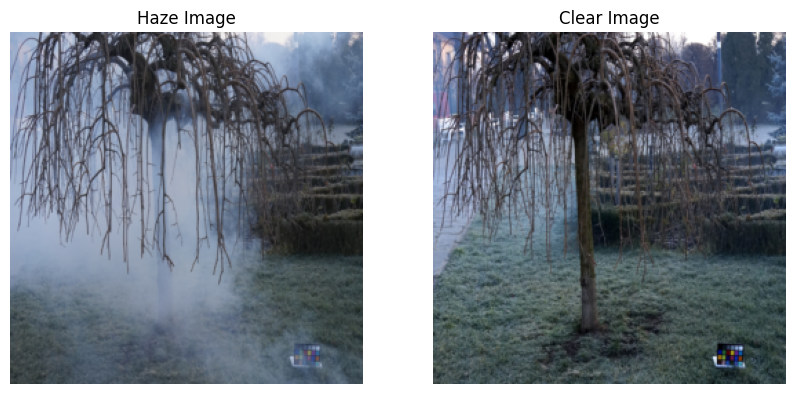

In [39]:
# Access an item from the dataset
index = 1  # Change this to test different images
haze_image, clear_image = nhhaze_dataset[index]

# print(haze_image)
# Visualize the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(haze_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Haze Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clear_image.permute(1, 2, 0))  # Permute dimensions for visualization
plt.title("Clear Image")
plt.axis("off")

plt.show()


In [41]:
from sklearn.model_selection import train_test_split

# Indices for splitting
total_size = len(nhhaze_dataset)
indices = list(range(total_size))

# Split indices: 45 training, 5 validation, 5 test
train_indices, test_indices = train_test_split(indices, test_size=10, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=5, random_state=42)

print(f'Training indices: {len(train_indices)}')
print(f'Validation indices: {len(val_indices)}')
print(f'Test indices: {len(test_indices)}')

# Create Subset datasets
train_dataset = Subset(nhhaze_dataset, train_indices)
val_dataset = Subset(nhhaze_dataset, val_indices)
test_dataset = Subset(nhhaze_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example usage
print("Number of training samples:", len(train_loader))
print("Number of validation samples:", len(val_loader))
print("Number of test samples:", len(test_loader))



Training indices: 45
Validation indices: 5
Test indices: 5
Number of training samples: 9
Number of validation samples: 5
Number of test samples: 5


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNET(in_channels = 3, out_channels = 3).to(device)
epochs = 100
lr = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './weights/model_20240517_032535.pth'
model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [43]:
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
log_file = os.path.join(log_dir, f"training_NHHAZE_FT_{timestamp}.log")
val_logfile = os.path.join(log_dir, f"val_NHHAZE_FT_{timestamp}.log")

def setup_logger(logger_name, log_file, level=logging.INFO):
    """Function to setup logger"""

    logger = logging.getLogger(logger_name)
    # Create a custom logger
    handler = logging.FileHandler(log_file)    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    
    handler.setFormatter(formatter)

    logger.setLevel(level)
    logger.addHandler(handler)
    
    return logger

train_log = setup_logger('train_log', log_file)
val_log = setup_logger('val_log', val_logfile)

In [44]:
history = train_and_evaluate(model, train_loader, val_loader, criterion, 
                optimizer, epochs, device, train_log, val_log, batch_size = 1, fine_tune = 'NHHAZE')

Training Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.0460, Val Loss: 0.0477, PSNR: 13.420045852661133, SSIM: 0.4529722571372986
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 2/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.0327, Val Loss: 0.0422, PSNR: 14.443239212036133, SSIM: 0.5082672834396362
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 3/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.0292, Val Loss: 563.7463, PSNR: 5.868035316467285, SSIM: 0.5197122037410736
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 4/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.0284, Val Loss: 0.0374, PSNR: 15.38549518585205, SSIM: 0.5425322830677033
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 5/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.0257, Val Loss: 0.0255, PSNR: 16.468481063842773, SSIM: 0.5602377831935883
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 6/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.0245, Val Loss: 0.0247, PSNR: 16.528409957885742, SSIM: 0.569889771938324
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 7/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.0235, Val Loss: 0.0267, PSNR: 16.09141731262207, SSIM: 0.5750484645366669
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 8/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.0226, Val Loss: 0.0244, PSNR: 16.595930099487305, SSIM: 0.5894468486309051
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 9/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.0215, Val Loss: 0.0282, PSNR: 15.923609733581543, SSIM: 0.5862404108047485
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 10/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.0200, Val Loss: 0.0285, PSNR: 15.994279861450195, SSIM: 0.5869132101535797
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 11/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.0199, Val Loss: 0.0277, PSNR: 16.3065185546875, SSIM: 0.5916601836681366
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 12/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.0206, Val Loss: 0.0282, PSNR: 15.992480278015137, SSIM: 0.5891771137714386
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 13/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.0191, Val Loss: 0.0295, PSNR: 15.963241577148438, SSIM: 0.5851292371749878
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 14/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.0182, Val Loss: 0.0311, PSNR: 15.398330688476562, SSIM: 0.5862378418445587
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 15/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.0176, Val Loss: 0.0292, PSNR: 15.68979549407959, SSIM: 0.5917085826396942
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 16/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.0168, Val Loss: 0.0273, PSNR: 16.048694610595703, SSIM: 0.6044528007507324
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 17/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.0165, Val Loss: 0.0308, PSNR: 15.792411804199219, SSIM: 0.5968139827251434
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 18/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.0174, Val Loss: 0.0276, PSNR: 15.937071800231934, SSIM: 0.6058221340179444
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 19/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.0158, Val Loss: 0.0285, PSNR: 15.794276237487793, SSIM: 0.601103687286377
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 20/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.0153, Val Loss: 0.0272, PSNR: 15.9639253616333, SSIM: 0.6053549349308014
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 21/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.0151, Val Loss: 0.0249, PSNR: 16.460960388183594, SSIM: 0.6164254784584046
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 22/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.0151, Val Loss: 0.0288, PSNR: 15.830575942993164, SSIM: 0.6024418234825134
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 23/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.0145, Val Loss: 0.0272, PSNR: 16.26205825805664, SSIM: 0.6134711563587188
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 24/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.0145, Val Loss: 0.0267, PSNR: 16.061140060424805, SSIM: 0.6178349673748016
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 25/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.0144, Val Loss: 0.0273, PSNR: 16.159912109375, SSIM: 0.6210097789764404
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 26/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.0138, Val Loss: 0.0256, PSNR: 16.4215145111084, SSIM: 0.624599027633667
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 27/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.0132, Val Loss: 0.0255, PSNR: 16.313735961914062, SSIM: 0.6224105715751648
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 28/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.0136, Val Loss: 0.0263, PSNR: 16.2877254486084, SSIM: 0.615662944316864
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 29/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 0.0117, Val Loss: 0.0278, PSNR: 16.20085334777832, SSIM: 0.6124704420566559
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 30/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 0.0122, Val Loss: 0.0293, PSNR: 15.790595054626465, SSIM: 0.6125026345252991
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 31/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 0.0130, Val Loss: 0.0315, PSNR: 15.603175163269043, SSIM: 0.6050554692745209
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 32/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 0.0127, Val Loss: 0.0297, PSNR: 15.898268699645996, SSIM: 0.6102024435997009
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 33/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 0.0121, Val Loss: 0.0293, PSNR: 15.936245918273926, SSIM: 0.6126966714859009
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 34/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 0.0119, Val Loss: 0.0275, PSNR: 16.1283016204834, SSIM: 0.6206791281700135
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 35/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 0.0113, Val Loss: 0.0288, PSNR: 15.886670112609863, SSIM: 0.6130414366722107
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 36/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 0.0116, Val Loss: 0.0287, PSNR: 15.990050315856934, SSIM: 0.6157685160636902
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 37/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 0.0116, Val Loss: 0.0282, PSNR: 16.12186050415039, SSIM: 0.618607497215271
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 38/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 0.0112, Val Loss: 0.0285, PSNR: 15.965553283691406, SSIM: 0.6137514114379883
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 39/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 0.0113, Val Loss: 0.0291, PSNR: 15.949745178222656, SSIM: 0.6108219027519226
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 40/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 0.0111, Val Loss: 0.0267, PSNR: 16.305936813354492, SSIM: 0.6185617566108703
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 41/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/100
Train Loss: 0.0112, Val Loss: 0.0280, PSNR: 16.11115074157715, SSIM: 0.6154574036598206
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 42/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/100
Train Loss: 0.0100, Val Loss: 0.0271, PSNR: 16.220718383789062, SSIM: 0.6195502161979676
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 43/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/100
Train Loss: 0.0104, Val Loss: 0.0272, PSNR: 16.276473999023438, SSIM: 0.6242031335830689
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 44/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/100
Train Loss: 0.0098, Val Loss: 0.0275, PSNR: 15.982281684875488, SSIM: 0.6221827864646912
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 45/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/100
Train Loss: 0.0107, Val Loss: 0.0260, PSNR: 16.248565673828125, SSIM: 0.6287194848060608
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 46/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/100
Train Loss: 0.0104, Val Loss: 0.0273, PSNR: 16.360004425048828, SSIM: 0.6248749971389771
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 47/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/100
Train Loss: 0.0100, Val Loss: 0.0254, PSNR: 16.40497589111328, SSIM: 0.6289379000663757
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 48/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/100
Train Loss: 0.0100, Val Loss: 0.0268, PSNR: 16.33388900756836, SSIM: 0.6236157298088074
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 49/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/100
Train Loss: 0.0100, Val Loss: 0.0245, PSNR: 16.549346923828125, SSIM: 0.6278651118278503
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 50/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/100
Train Loss: 0.0092, Val Loss: 0.0281, PSNR: 16.2678165435791, SSIM: 0.6242355227470398
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 51/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/100
Train Loss: 0.0095, Val Loss: 0.0280, PSNR: 16.304067611694336, SSIM: 0.6226743340492249
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 52/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/100
Train Loss: 0.0102, Val Loss: 0.0302, PSNR: 16.100675582885742, SSIM: 0.6171071171760559
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 53/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/100
Train Loss: 0.0095, Val Loss: 0.0276, PSNR: 16.254863739013672, SSIM: 0.6165568947792053
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 54/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/100
Train Loss: 0.0089, Val Loss: 0.0266, PSNR: 16.30353355407715, SSIM: 0.6227186322212219
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 55/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/100
Train Loss: 0.0092, Val Loss: 0.0257, PSNR: 16.579206466674805, SSIM: 0.6322454571723938
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 56/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/100
Train Loss: 0.0087, Val Loss: 0.0263, PSNR: 16.35613441467285, SSIM: 0.6302860617637634
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 57/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/100
Train Loss: 0.0091, Val Loss: 0.0253, PSNR: 16.536643981933594, SSIM: 0.6297945857048035
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 58/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/100
Train Loss: 0.0087, Val Loss: 0.0264, PSNR: 16.491886138916016, SSIM: 0.6332402348518371
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 59/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/100
Train Loss: 0.0086, Val Loss: 0.0259, PSNR: 16.273666381835938, SSIM: 0.6284176349639893
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 60/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/100
Train Loss: 0.0087, Val Loss: 0.0250, PSNR: 16.50405502319336, SSIM: 0.6353183150291443
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 61/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/100
Train Loss: 0.0084, Val Loss: 0.0244, PSNR: 16.519529342651367, SSIM: 0.6382305741310119
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 62/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/100
Train Loss: 0.0085, Val Loss: 0.0243, PSNR: 16.662805557250977, SSIM: 0.6391742110252381
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 63/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/100
Train Loss: 0.0094, Val Loss: 0.0262, PSNR: 16.320432662963867, SSIM: 0.6293912649154663
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 64/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/100
Train Loss: 0.0082, Val Loss: 0.0257, PSNR: 16.529592514038086, SSIM: 0.6366995096206665
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 65/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/100
Train Loss: 0.0086, Val Loss: 0.0286, PSNR: 16.094472885131836, SSIM: 0.6212062120437623
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 66/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/100
Train Loss: 0.0085, Val Loss: 0.0262, PSNR: 16.42411231994629, SSIM: 0.6348697304725647
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 67/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/100
Train Loss: 0.0079, Val Loss: 0.0269, PSNR: 16.275592803955078, SSIM: 0.6322205781936645
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 68/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/100
Train Loss: 0.0084, Val Loss: 0.0282, PSNR: 16.111303329467773, SSIM: 0.628131115436554
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 69/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69/100
Train Loss: 0.0086, Val Loss: 0.0257, PSNR: 16.454574584960938, SSIM: 0.6351473927497864
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 70/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70/100
Train Loss: 0.0080, Val Loss: 0.0269, PSNR: 16.389545440673828, SSIM: 0.6371402025222779
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 71/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71/100
Train Loss: 0.0078, Val Loss: 0.0241, PSNR: 16.550256729125977, SSIM: 0.6406052470207214
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 72/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72/100
Train Loss: 0.0081, Val Loss: 0.0271, PSNR: 16.38277816772461, SSIM: 0.6330553650856018
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 73/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73/100
Train Loss: 0.0075, Val Loss: 0.0276, PSNR: 16.386091232299805, SSIM: 0.634491229057312
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 74/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74/100
Train Loss: 0.0080, Val Loss: 0.0250, PSNR: 16.60493278503418, SSIM: 0.6438250780105591
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 75/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75/100
Train Loss: 0.0083, Val Loss: 0.0236, PSNR: 16.769819259643555, SSIM: 0.6469098687171936
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 76/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76/100
Train Loss: 0.0078, Val Loss: 0.0251, PSNR: 16.592321395874023, SSIM: 0.643241286277771
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 77/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77/100
Train Loss: 0.0073, Val Loss: 0.0238, PSNR: 16.748655319213867, SSIM: 0.6474472999572753
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 78/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78/100
Train Loss: 0.0080, Val Loss: 0.0273, PSNR: 16.236812591552734, SSIM: 0.6327826976776123
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 79/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79/100
Train Loss: 0.0085, Val Loss: 0.0258, PSNR: 16.504966735839844, SSIM: 0.6373804450035095
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 80/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80/100
Train Loss: 0.0074, Val Loss: 0.0254, PSNR: 16.529386520385742, SSIM: 0.641058373451233
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 81/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81/100
Train Loss: 0.0079, Val Loss: 0.0287, PSNR: 16.14257049560547, SSIM: 0.6297147750854493
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 82/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82/100
Train Loss: 0.0074, Val Loss: 0.0273, PSNR: 16.377029418945312, SSIM: 0.634883725643158
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 83/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83/100
Train Loss: 0.0074, Val Loss: 0.0263, PSNR: 16.40452003479004, SSIM: 0.6417310953140258
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 84/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84/100
Train Loss: 0.0077, Val Loss: 0.0237, PSNR: 16.669815063476562, SSIM: 0.649821937084198
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 85/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85/100
Train Loss: 0.0073, Val Loss: 0.0249, PSNR: 16.591251373291016, SSIM: 0.6464803218841553
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 86/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86/100
Train Loss: 0.0072, Val Loss: 0.0249, PSNR: 16.548856735229492, SSIM: 0.6460236191749573
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 87/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87/100
Train Loss: 0.0080, Val Loss: 0.0238, PSNR: 16.78925323486328, SSIM: 0.6503208637237549
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 88/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88/100
Train Loss: 0.0073, Val Loss: 0.0259, PSNR: 16.374832153320312, SSIM: 0.6420093774795532
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 89/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89/100
Train Loss: 0.0076, Val Loss: 0.0263, PSNR: 16.45790672302246, SSIM: 0.6418160319328308
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 90/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90/100
Train Loss: 0.0078, Val Loss: 0.0247, PSNR: 16.52090072631836, SSIM: 0.6396444320678711
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 91/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91/100
Train Loss: 0.0071, Val Loss: 0.0243, PSNR: 16.794113159179688, SSIM: 0.6479421377182006
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 92/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92/100
Train Loss: 0.0067, Val Loss: 0.0249, PSNR: 16.388978958129883, SSIM: 0.6412393808364868
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 93/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93/100
Train Loss: 0.0071, Val Loss: 0.0256, PSNR: 16.483388900756836, SSIM: 0.6463971376419068
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 94/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94/100
Train Loss: 0.0075, Val Loss: 0.0259, PSNR: 16.475217819213867, SSIM: 0.6467758655548096
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 95/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95/100
Train Loss: 0.0066, Val Loss: 0.0245, PSNR: 16.708984375, SSIM: 0.6499589443206787
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 96/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96/100
Train Loss: 0.0066, Val Loss: 0.0248, PSNR: 16.634836196899414, SSIM: 0.6512895345687866
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 97/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97/100
Train Loss: 0.0067, Val Loss: 0.0235, PSNR: 16.686887741088867, SSIM: 0.6518930077552796
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 98/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98/100
Train Loss: 0.0071, Val Loss: 0.0250, PSNR: 16.545026779174805, SSIM: 0.6472323179244995
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 99/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99/100
Train Loss: 0.0069, Val Loss: 0.0246, PSNR: 16.56524658203125, SSIM: 0.6460953831672669
Model saved as weights/model_NHHAZE_20240517_084723.pth


Training Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 100/100:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100/100
Train Loss: 0.0074, Val Loss: 0.0219, PSNR: 17.119638442993164, SSIM: 0.6578222751617432
Model saved as weights/model_NHHAZE_20240517_084723.pth


In [45]:
valid_per_epoch(model, test_loader, criterion, device, 0, 
                    100, val_log, batch_size = 1, display = False)

Validation Epoch 1/100:   0%|          | 0/5 [00:00<?, ?it/s]

(0.019451124593615532, tensor(17.1773, device='cuda:0'), 0.7121631979942322)

In [ ]:
def inference_lol(test_dataset, model, model_path = './weights/model_NHHAZE_20240517_084723.pth'):

    for i in range(len(test_dataset)):
        haze_image, clean_image = test_dataset[i]
        haze_image, clean_image = haze_image.to(device), clean_image.to(device)
        
        model = model.to(device)
        model.load_state_dict(torch.load(model_path))
        
        with torch.no_grad():
            denoised_image = model(haze_image.unsqueeze(0).cuda())
            print(f"PSNR:{psnr(denoised_image, clean_image.to(device))}")
        
        
        # Convert PyTorch tensors to numpy arrays
        haze_np = haze_image.permute(1, 2, 0).cpu().numpy()  # Assuming haze_image is a PyTorch tensor
        denoised_np = denoised_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming denoised_image is a PyTorch tensor
        clean_np = clean_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Assuming clean_image is a PyTorch tensor
        
        # Calculate SSIM
        ssim_value = ssim(denoised_np, clean_np, 
                          multichannel = True, channel_axis = -1, data_range = 1)
         # Assuming images are in RGB format
        print(f"SSIM: {ssim_value}")
        
        # Plot the haze image, denoised image, and clean image
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        
        axes[0].imshow(haze_np)
        axes[0].set_title('Haze Image')
        axes[0].axis('off')
        
        axes[1].imshow(denoised_np)
        axes[1].set_title('Denoised Image')
        axes[1].axis('off')
        
        axes[2].imshow(clean_np)
        axes[2].set_title('Clean Image')
        axes[2].axis('off')
        
        plt.show()

inference_lol(train_dataset, model)